In [109]:
import networkx as nx
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import powerlaw

import arrow

from scipy.special import factorial
from math import e

### Load Project Data

In [110]:
projects = [
    'bayc', 
    'coolcats', 
    'cryptoadz', 
    'cyberkongz', 
    'hashmasks', 
    'mayc', 
    'meebits', 
    'mekaverse', 
    'svs'
]

In [111]:
df_summaries = {}

column_names = [
    "date", 
    "days_since_mint", 
    "from_address", 
    "to_address", 
    "token_id", 
    "blk_number", 
    "eth_value", 
    "usd_value", 
    "from_value", 
    "to_value", 
    "from_value_usd", 
    "to_value_usd"
]

for project in projects:
    np_data = np.load(f"./memory/{project}/full.npy", allow_pickle=True)
    df_summaries[project] = pd.DataFrame(data=np_data, columns=column_names).infer_objects()

### ETH inflows over DSM

In [112]:
def plot_eth_over_dsm(dfs):
    sort = lambda x: x.sort_values(by=['days_since_mint'])
    group = lambda x: x.groupby(by=['days_since_mint']).sum()
    
    keys = [key for key in dfs.keys()]

    fig, axs = plt.subplots(5, 2, figsize=(20, 32))
    fig.suptitle('ETH Inflows over Days Since Mint', y=0.90, fontsize=20)
    
    for i, ax in enumerate(axs.flatten()):
        try:
            df = group(sort(dfs[keys[i]]))
            ax.plot(df.index, df.eth_value, color='b')
            ax.set_title(keys[i])
            ax.set_xlabel("days since mint")
            ax.set_ylabel("ETH value inflow")
            ax.set_yscale("log")
        except IndexError:
            pass

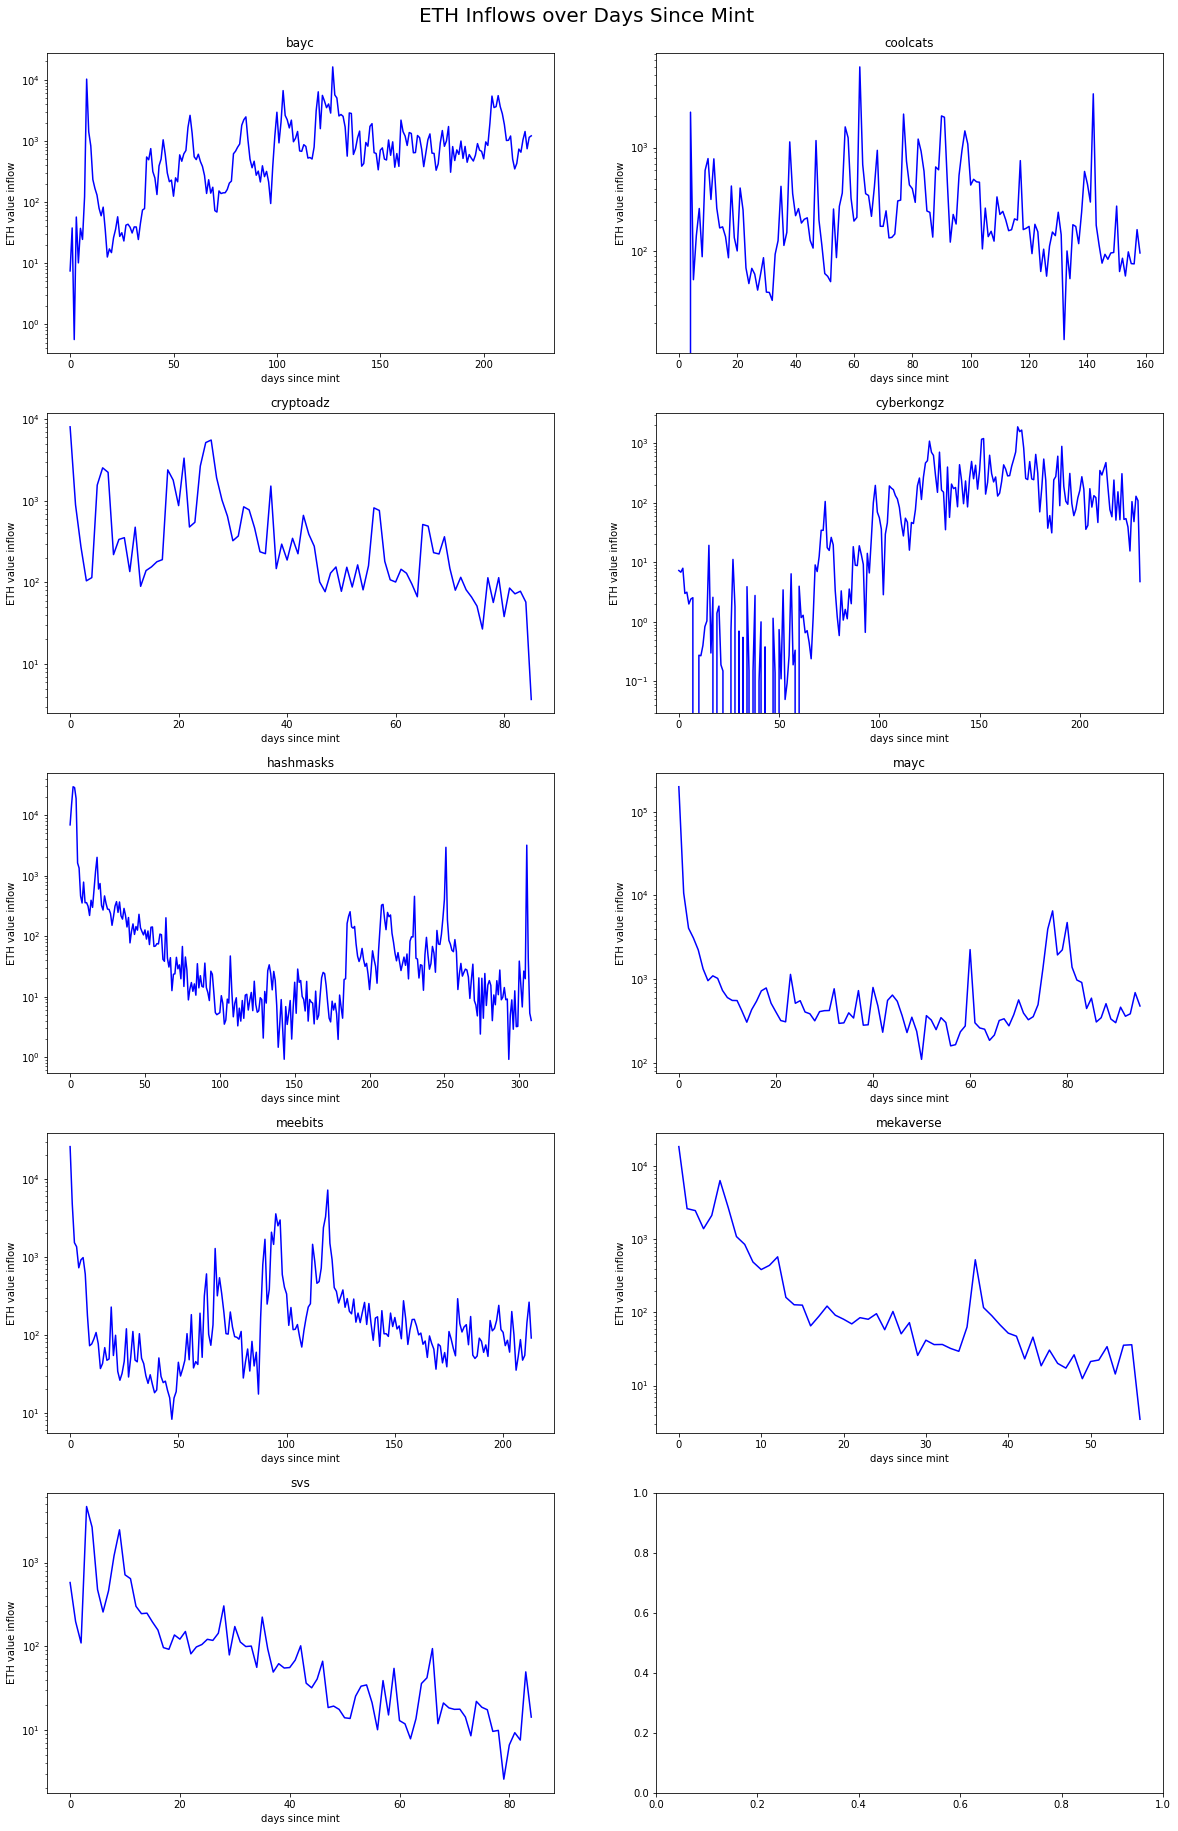

In [113]:
plot_eth_over_dsm(df_summaries)

### Plot USD value over days since mint

In [114]:
def plot_usd_over_dsm(dfs):
    sort = lambda x: x.sort_values(by=['days_since_mint'])
    group = lambda x: x.groupby(by=['days_since_mint']).sum()
    
    keys = [key for key in dfs.keys()]

    fig, axs = plt.subplots(5, 2, figsize=(20, 32))
    fig.suptitle('USD Inflows over Days Since Mint', y=0.90, fontsize=20)
    
    for i, ax in enumerate(axs.flatten()):
        try:
            df = group(sort(dfs[keys[i]]))
            ax.plot(df.index, df.usd_value, color='b')
            ax.set_title(keys[i])
            ax.set_xlabel("days since mint")
            ax.set_ylabel("USD value inflow")
            ax.set_yscale("log")
        except IndexError:
            pass

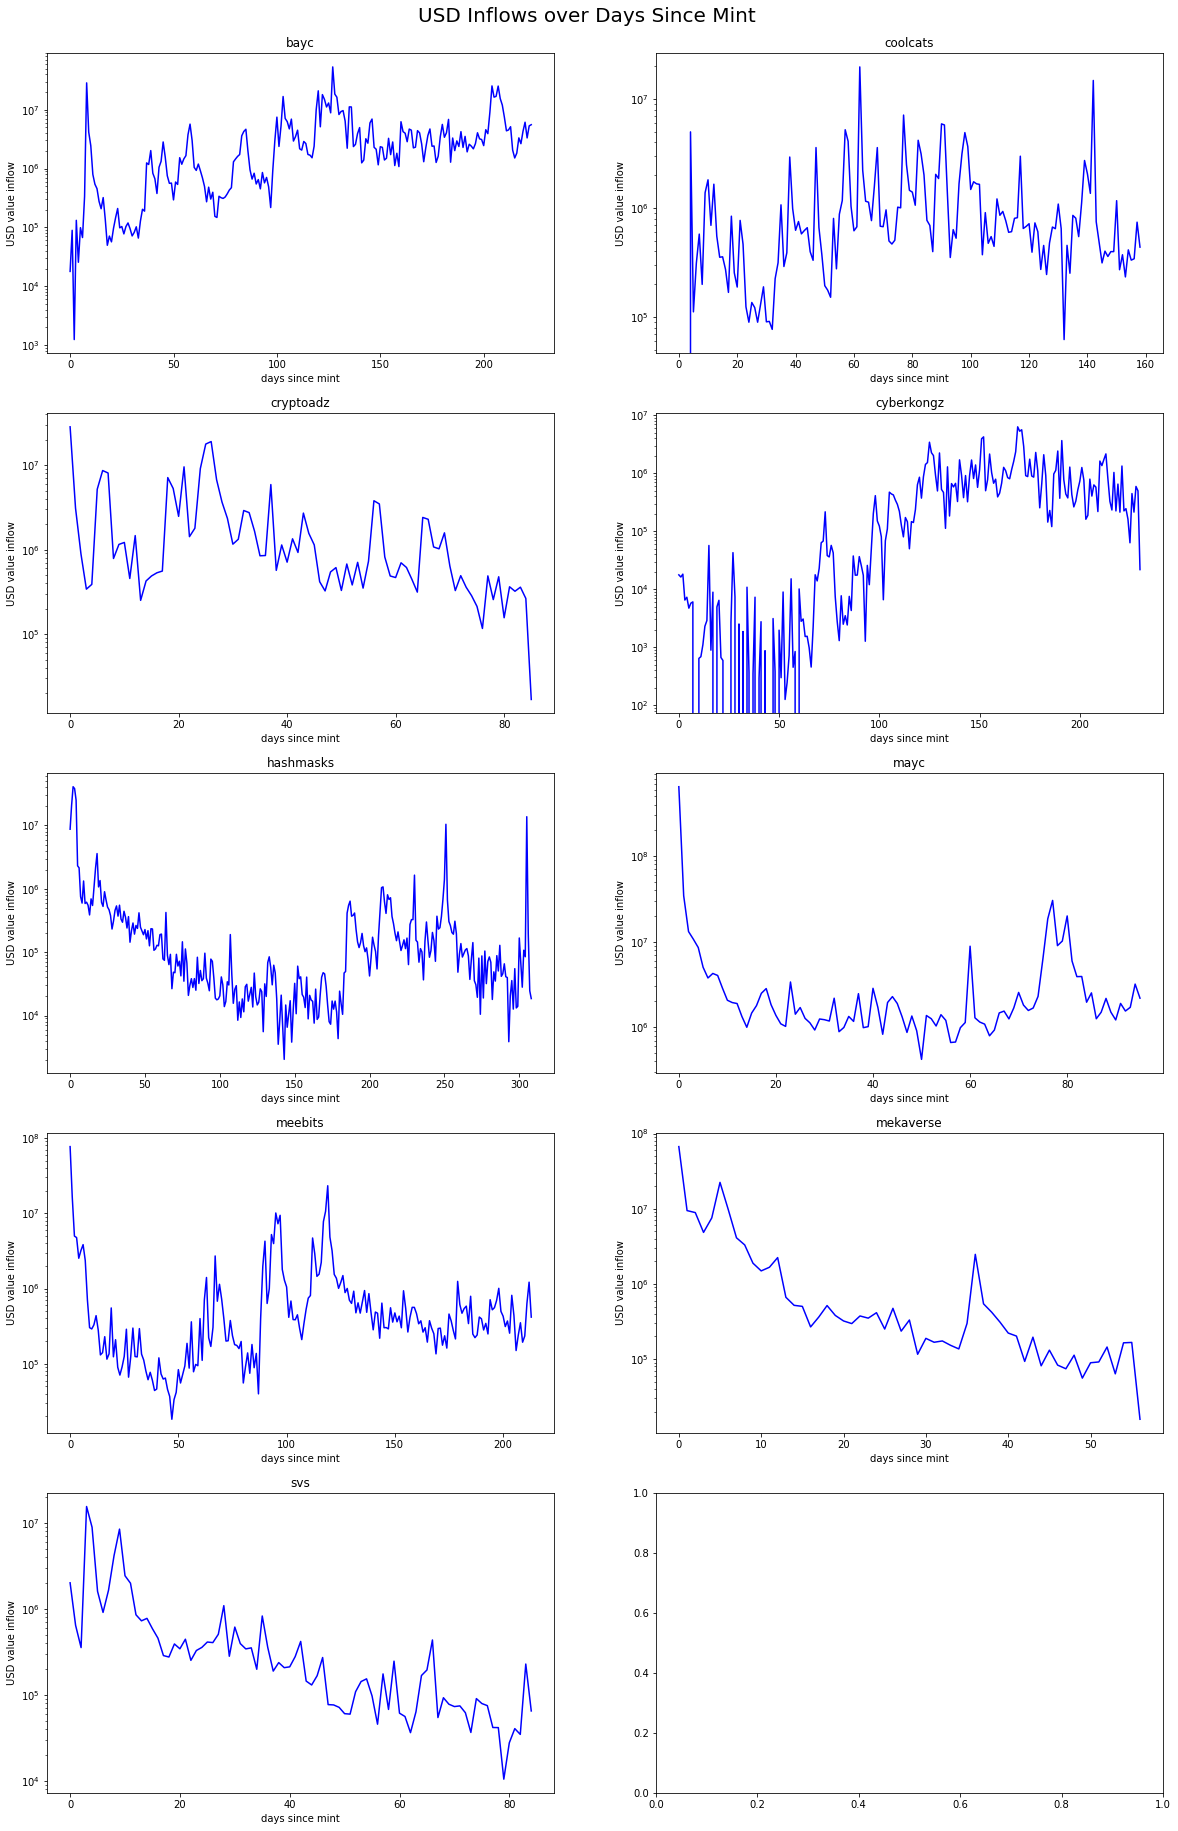

In [115]:
plot_usd_over_dsm(df_summaries)

### Plot number of transactions over time

In [116]:
def plot_transactions_over_dsm(dfs):
    keys = [key for key in dfs.keys()]

    fig, axs = plt.subplots(5, 2, figsize=(20, 32))
    fig.suptitle('Transactions over Days Since Mint', y=0.90, fontsize=20)
    
    for i, ax in enumerate(axs.flatten()):
        try:
            df = dfs[keys[i]]
            ax.hist(df.days_since_mint, bins=100, color='b')
            ax.set_title(keys[i])
            ax.set_xlabel("days since mint")
            ax.set_ylabel("transactions")
            ax.set_yscale("log")
        except IndexError:
            pass

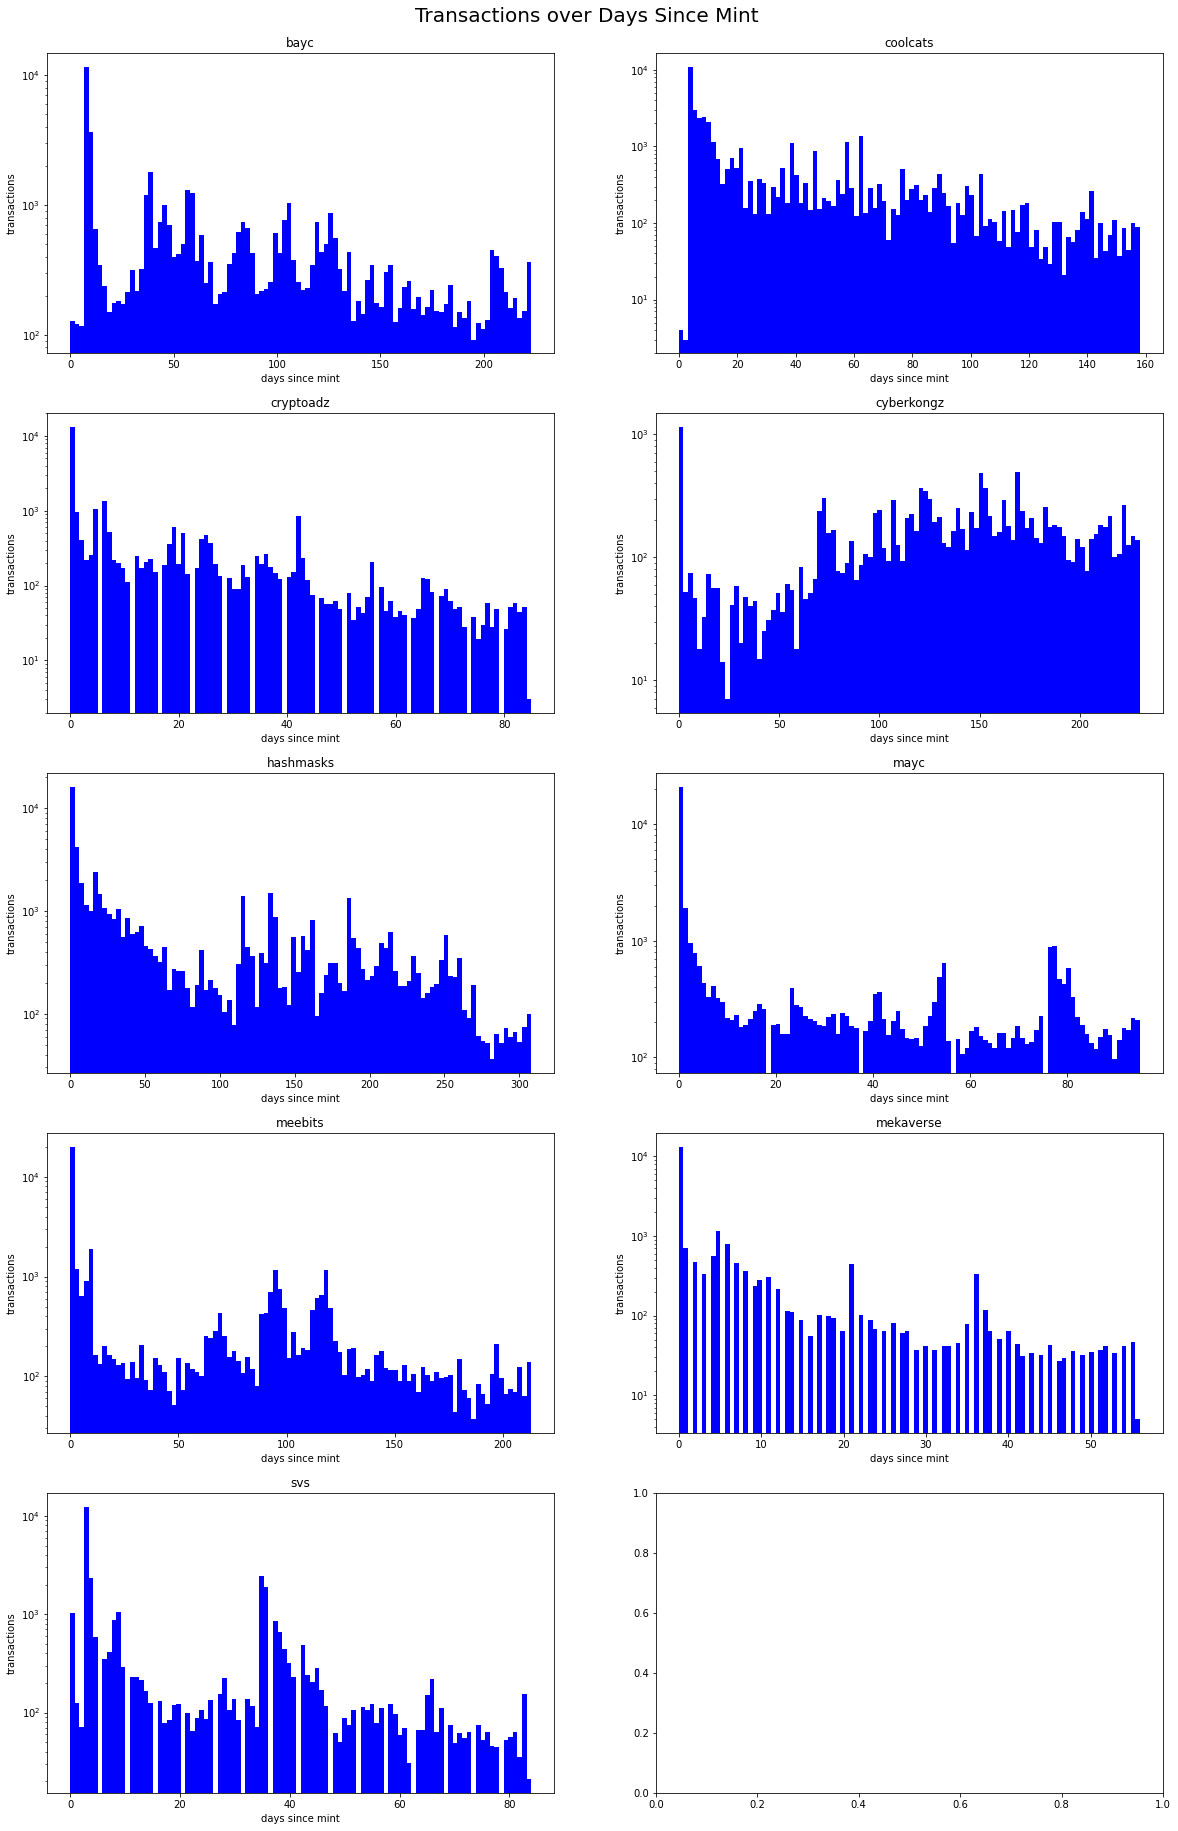

In [117]:
plot_transactions_over_dsm(df_summaries)

### Plot centrality measures

In [111]:
def scatter_network_centrality(graph, centrality_measure_1, centrality_measure_2):
    labels = {
        "centrality_degree": "Degree Centrality",
        "centrality_closeness": "Closeness Centrality",
        "centrality_betweenness": "Betweenness Centrality",
        "centrality_eigenvector": "Eigenvector Centrality"
    }
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x_label = labels[centrality_measure_1]
    y_label = labels[centrality_measure_2]
    
    x_series = list(graph[centrality_measure_1].values())
    y_series = list(graph[centrality_measure_2].values())

    fig.suptitle(f'{graph["project"]} - {x_label} vs. {y_label}', fontsize=20, y=1.1, ha="center")
    plt.scatter(x_series, y_series)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

KeyError: 'centrality_degree'

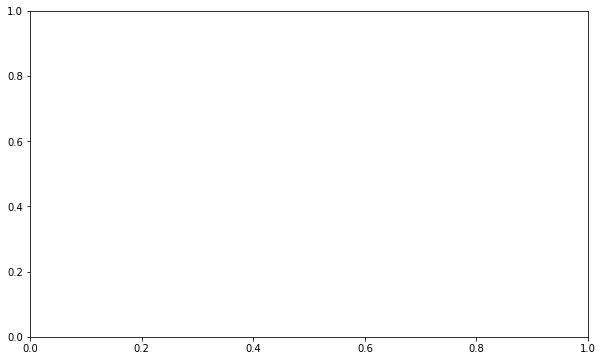

In [112]:
centralities = ['centrality_degree', 'centrality_closeness', 'centrality_betweenness', 'centrality_eigenvector']

centrality_pairs = [
    ('centrality_degree', 'centrality_closeness'),
    ('centrality_degree', 'centrality_betweenness'),
    ('centrality_degree', 'centrality_eigenvector'),
    ('centrality_closeness', 'centrality_betweenness'),
    ('centrality_closeness', 'centrality_eigenvector'),
    ('centrality_betweenness', 'centrality_eigenvector'),
]

for pair in centrality_pairs:
    for project, graph in graphs.items():
        scatter_network_centrality(graph, pair[0], pair[1])

### Build snapshot graphs at different time periods

In [ ]:
# def build_graph_snapshots(df_time, project):
#     """Simpler version of below function which just returns the graph objects"""
#     res = {}
    
#     df_time['date_quantile'], bins = pd.qcut(df_time['date'], 10, labels=False, retbins=True)
#     time_buckets = np.unique(df_time["date_quantile"].to_numpy())
    
#     for time_bucket, label in zip(time_buckets, bins):
#         selection = df_time[(df_time['date_quantile'] == time_bucket)]
#         graph_snapshot = build_graph_from_timed(selection)
#         graph_snapshot_random = nx.algorithms.smallworld.random_reference(graph_snapshot.to_undirected(), niter=10, connectivity=False)
        
#         res[label] = (graph_snapshot, graph_snapshot_random)
        
#     return res


# def build_df_snapshots(df_time, project):
#     column_names = [
#         "time_bucket", 
#         "time_bucket_label",
#         "number_of_nodes", 
#         "avg_clustering", 
#         "reciprocity", 
#         "assortativity", 
#         "assortativity_base", 
#         "assortativity_out_out", 
#         "assortativity_in_in", 
#         "assortativity_in_out",
#         "centrality_degree",
#         "centrality_closeness", 
#         "centrality_betweenness",
#         "centrality_eigenvector",
#         "avg_clustering_random",
#         "assortativity_random"
#     ]
    
#     df_snapshots = pd.DataFrame(columns=column_names)
    
#     df_time['date_quantile'], bins = pd.qcut(df_time['date'], 10, labels=False, retbins=True)
#     time_buckets = np.unique(df_time["date_quantile"].to_numpy())
    
#     for time_bucket, label in zip(time_buckets, bins):
#         selection = df_time[(df_time['date_quantile'] == time_bucket)]
#         graph_snapshot = build_graph_from_timed(selection)
#         graph_snapshot_random = nx.algorithms.smallworld.random_reference(graph_snapshot.to_undirected(), niter=10, connectivity=False)
        
#         df_snapshots = df_snapshots.append({
#             "time_bucket": time_bucket,
#             "time_bucket_label": label,
#             "number_of_nodes": graph_snapshot.number_of_nodes(),
#             "avg_clustering": nx.average_clustering(graph_snapshot),
#             "reciprocity": nx.reciprocity(graph_snapshot),
#             "assortativity": nx.degree_assortativity_coefficient(graph_snapshot),
#             "assortativity_base": nx.degree_pearson_correlation_coefficient(graph_snapshot.to_undirected(), weight='weight'),
#             "assortativity_out_out": nx.degree_pearson_correlation_coefficient(graph_snapshot, x='out', y='out', weight='weight'),
#             "assortativity_in_in": nx.degree_pearson_correlation_coefficient(graph_snapshot, x='in', y='in', weight='weight'),
#             "assortativity_in_out": nx.degree_pearson_correlation_coefficient(graph_snapshot, x='in', y='out', weight='weight'),
#             "centrality_degree": nx.degree_centrality(graph_snapshot),
#             "centrality_closeness": nx.closeness_centrality(graph_snapshot),
#             "centrality_betweenness": nx.betweenness_centrality(graph_snapshot),
#             "avg_clustering_random": nx.average_clustering(graph_snapshot_random),
#             "assortativity_random": nx.degree_assortativity_coefficient(graph_snapshot_random)
#             # "centrality_eigenvector": nx.eigenvector_centrality(graph_snapshot) # was causing problems
#         }, ignore_index=True)
        
#     return df_snapshots.sort_values(by=['time_bucket'])

In [ ]:
dataframes_snapshots = {}
graph_snapshots = {}

for project, df_time in dataframes_time.items():
    dataframes_snapshots[project] = build_df_snapshots(df_time, project)
    graph_snapshots[project] = build_graph_snapshots(df_time, project)

### Plot snapshot characteristics

In [ ]:
# This code is just a quick demo and might need to be changed when multiple projects are run
# Because the plots write over one another
def plot_snapshot_attributes_over_time(df_snapshots, attribute, project):
    df_snapshots = df_snapshots.sort_values(by=['time_bucket_label'])
    
    fig = plt.figure(1, figsize=(10, 6), dpi=60)   
    fig.suptitle('Network Characteristics over Time', fontsize=20, y=1, ha="center")

    plt.xlabel("Time Period")
    plt.ylabel(attribute)
    
    plt.plot(df_snapshots['time_bucket'], df_snapshots[attribute], label=project, color=colors[project])
        
    plt.legend(bbox_to_anchor=(1.05, 1))

In [ ]:
for project, df_snapshots in dataframes_snapshots.items():
    plot_snapshot_attributes_over_time(df_snapshots, 'number_of_nodes', project)

In [ ]:
for project, df_snapshots in dataframes_snapshots.items():
    plot_snapshot_attributes_over_time(df_snapshots, 'reciprocity', project)

In [ ]:
for project, df_snapshots in dataframes_snapshots.items():
    plot_snapshot_attributes_over_time(df_snapshots, 'assortativity_base', project)

In [ ]:
def plot_snapshot_attributes_over_nodes(df_snapshots, y_list, y_colors):
    df_snapshots = df_snapshots.sort_values(by=['number_of_nodes'])
    
    fig = plt.figure(1, figsize=(10, 6), dpi=60)   
    fig.suptitle('Network Characteristics over Time', fontsize=20, y=1, ha="center")

    plt.xlabel("Number of Nodes")
    plt.ylabel("Attribute")
    
    for i, y in enumerate(y_list):
        plt.plot(df_snapshots['number_of_nodes'], df_snapshots[y], label=y, color=y_colors[i])
        
    plt.legend(bbox_to_anchor=(1.05, 1))

In [ ]:
for project, df_snapshots in dataframes_snapshots.items():
    plot_snapshot_attributes_over_nodes(df_snapshots, ['avg_clustering', 'avg_clustering_random'], ['b', 'orange'])

In [ ]:
for project, df_snapshots in dataframes_snapshots.items():
    plot_snapshot_attributes_over_nodes(df_snapshots, ['assortativity', 'assortativity_random'], ['b', 'orange'])

In [ ]:
for project, df_snapshots in dataframes_snapshots.items():
    plot_snapshot_attributes_over_nodes(df_snapshots, ['assortativity_base', 'assortativity_out_out', "assortativity_in_in", "assortativity_in_out"], ['b', 'orange', 'red', 'green'])

### Power law analysis

In [ ]:
def pure(x, alpha):
    return x**(-alpha)

def poisson(k, avg_degree):
    return (np.exp(-1 * avg_degree) * np.power(avg_degree, k)) / factorial(k)

def exp(k, avg_degree):
    return ((1/avg_degree) * np.exp((k * (-1)) / avg_degree))

def round_float(x):
    if x in [float("-inf"),float("inf")]: return float(0)
    return x

In [ ]:
def plot_graph_power_law(g,project):
    k = np.asarray([d for d in dict(g.degree()).values()])
    avg_degree = sum(k) / len(g.nodes())

    spacing = np.linspace(min(k),max(k),len(k))
    
    fit = powerlaw.Fit(k)
    
    alpha = fit.power_law.alpha
    sigma = fit.power_law.sigma
    
    # This guy is causing problems unfortunately 
    # fit.power_law.plot_pdf(color='b', linestyle='--', label="Fit PDF")
    
    plt.plot(spacing, pure(spacing, alpha), color='r', label='Pure alpha Fit')
    plt.plot(spacing, poisson(spacing, avg_degree), color='g', label="Poisson Dist.")
    plt.plot(spacing, exp(spacing, avg_degree), color='orange', label="Exponential Dist.")
    
    plt.legend()
    plt.title(project)
    
    plt.xlabel("k")
    plt.ylabel("p(k)")

    plt.annotate("alpha: {:.2f}\nsigma: {:.2f}".format(alpha, sigma), xy=(0.80, 0.85), xycoords='axes fraction')
    
    plt.ylim(0.000000001, 1)

In [ ]:
for project, graph in graphs.items():
    plot_graph_power_law(graph['graph'], project)